# Neural sequences
As discussed in the class, sequential neural activity patterns have been observed throughout the brain - In hippocampus during spatial and cognitive navigation$^1$, in posterior parietal cortex during decision making$^2$, and in songbird motor regions$^3$. In this question, we will explore in greater detail the dynamics of these sequences, how they might be learned, and what kind of neural architectures might support them.

## Note to Rolando
I've rewritten much of the code below, not because there was anything wrong with it, but because writing the code out for myself is the most helpful way for me to learn the mathematics. I hope you don't take offense at the code below. As a sanity check, I made sure our code generated the same outputs.

All the best,
<br> Sam

<br>
## 1. Dynamics of sequence generation

### 1.1 Getting started: single neuron sequences
Here we have a simulation of 50 binary neurons, that are either active ($x_i$=1) or inactive ($x_i$=0) at timestep $t$. The activity of the $i$th neuron is given by 

$$x_i(t) = \Theta\bigl(I_i^E(t-1) + I^{I global}(t-1)\bigr)$$

where $\Theta$ is the heaviside step function (meaning it is zero if its input is less or equal to zero, and 1 if its input is greater than zero), $I_i^E(t) = \Sigma_j W_{ij}x_j(t) + b_i(t)$ is the summed excitatory drive to the neuron, with $W_{ij}$ the strength of the connection from neuron $j$ to $i$. $b_i \in \{ 0,1 \} $ is the external input. Global inhibition is given by $I^{I global}(t) = -\beta \Sigma_jx_j(t)$. External inputs $b_i(t)$ are i.i.d for each neuron in each timestep with probability $p(b_i(t) = 1)=p_{in}$.

a) Run the simulation below, and the network will generate activity ($X_{dyn}$) for all 50 neurons (rows) for 200 timesteps (columns). Does the activity have any sequential patterns? You might have to sort the neurons in order to visualize this. Plot the final sorted activity.

b) Lets explore what happens to the sequence if one of the neurons fails to fire. Ablate a random neuron and run the simulation again visualising neural activity.  Repeat this for 5 more randomly chosen neurons, making sure that on each try only one neuron in the network is ablated. Explain what you observe.

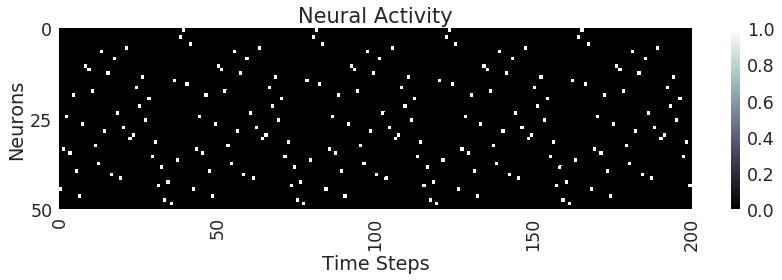

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
sns.set_style('white')
sns.set_context('notebook', font_scale=1.75)
%matplotlib inline

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Load data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Load data.
mat = loadmat('params_1_1.mat')

## Extract data.
W    = mat['w']      # Connectivity matrix.
B_e  = mat['binput'] # External input.
x0   = mat['oldx']   # Activity from previous timestep (initial conditions).
N, T = B_e.shape     # Number of neurons, number of times

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Simulate network activity.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define global inhibition.
B_i = 0.25

## Preallocate space.
X = np.zeros_like(B_e)
X[:,0] = x0.squeeze() # Store initial activity.

## Main loop.
for i in range(1, T):
    
    ## Compute excitatory inputs.
    I_e = W.dot(X[:,i-1]) + B_e[:,i-1]
    
    ## Compute inhibitory inputs.
    I_i = B_i * np.sum(X[:,i-1])
    
    ## Summate inputs, threshold, and store.
    X[:,i] = np.where(I_e - I_i > 0, 1, 0)
    
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plot.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
        
## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(12,4))
    
## Plot.
sns.heatmap(X, cmap='bone')
ax.set(xticks=np.linspace(0,T,5), xticklabels=np.linspace(0,T,5,dtype=int), xlabel='Time Steps', 
       yticks=np.linspace(0,N,3), yticklabels=np.linspace(0,N,3,dtype=int), ylabel='Neurons', 
       title='Neural Activity');
plt.tight_layout()

### 1.1a Answer
After sorting the neurons by onset of first spike, it is apparent there is a sequential pattern of activity in the network.

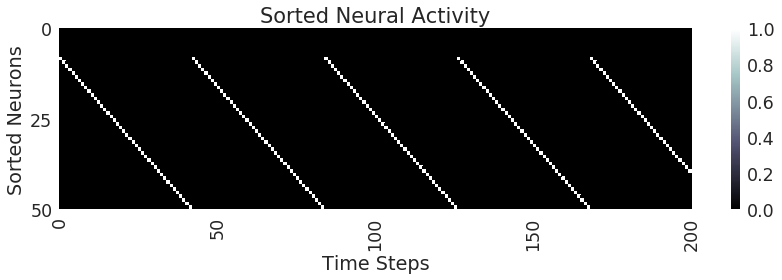

In [2]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Sort network activity.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Identify first onset of firing for each neuron.
f = lambda arr: -1 if not arr.sum() else np.argmax(arr)
first_onset = np.apply_along_axis(f, 1, X)

## Generate sorting indices by first onset.
sort_ix = np.argsort(first_onset)
ix1 = sort_ix.copy()

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plot.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
        
## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(12,4))
    
## Plot.
sns.heatmap(X[sort_ix], cmap='bone')
ax.set(xticks=np.linspace(0,T,5), xticklabels=np.linspace(0,T,5,dtype=int), xlabel='Time Steps', 
       yticks=np.linspace(0,N,3), yticklabels=np.linspace(0,N,3,dtype=int), ylabel='Sorted Neurons', 
       title='Sorted Neural Activity');
plt.tight_layout()

### 1.1b Answer
To ablate a neuron is to remove the effects of a neuron on the network. We simulate this by removing its connections. We do this for the 10th, 20th, 30th, 40th, and 50th neurons, where the rank corresponds to the sorted index as generated in 1.1a. As can be observed, ablating the neuron stops the flow of activity in the network.

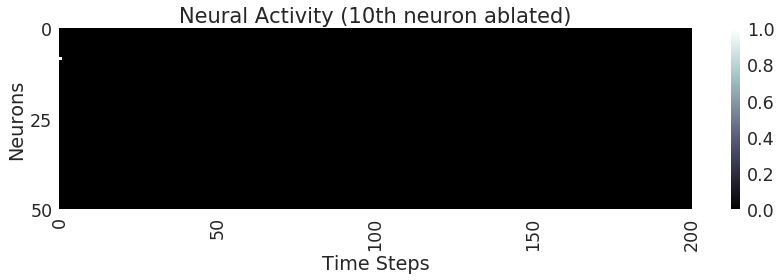

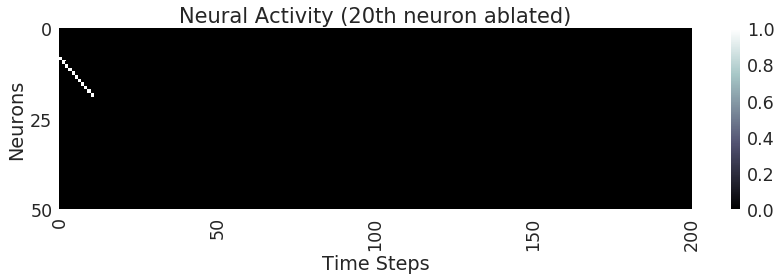

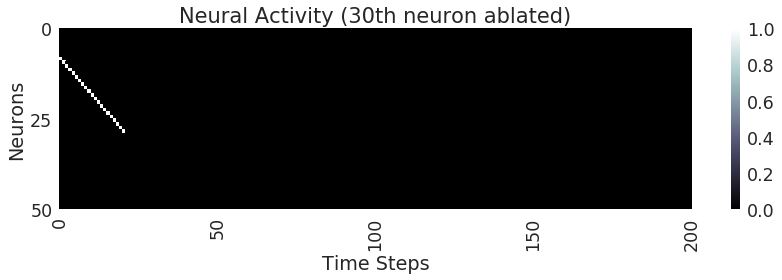

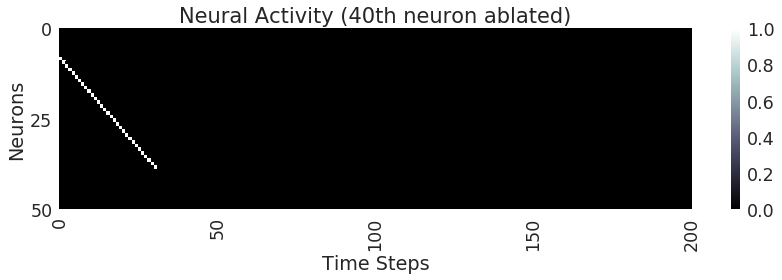

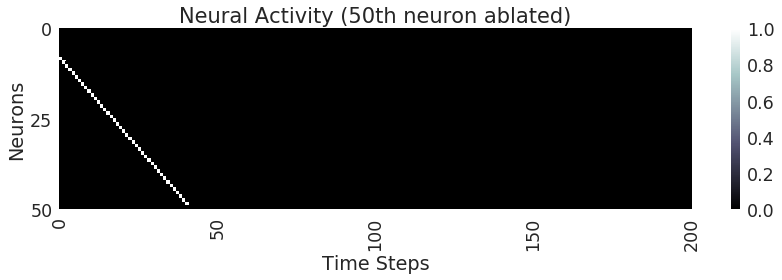

In [3]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define neurons to ablate.
targets = np.arange(10,51,10) - 1 # 0-indexing

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main loop.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

for target in targets:

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Ablate neuron.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    
    ## Define index.
    ix = sort_ix[target]
    
    ## Ablate connections.
    Wcopy = W.copy()
    Wcopy[ix] = 0
        
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Simulate network activity.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

    ## Preallocate space.
    X = np.zeros_like(B_e)
    X[:,0] = x0.squeeze() # Store initial activity.

    ## Main loop.
    for i in range(1, T):

        ## Compute excitatory inputs.
        I_e = Wcopy.dot(X[:,i-1]) + B_e[:,i-1]

        ## Compute inhibitory inputs.
        I_i = B_i * np.sum(X[:,i-1])

        ## Summate inputs, threshold, and store.
        X[:,i] = np.where(I_e - I_i > 0, 1, 0)

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Plot.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

    ## Initialize canvas.
    fig, ax = plt.subplots(1,1,figsize=(12,4))

    ## Plot.
    sns.heatmap(X[sort_ix], cmap='bone')
    ax.set(xticks=np.linspace(0,T,5), xticklabels=np.linspace(0,T,5,dtype=int), xlabel='Time Steps', 
           yticks=np.linspace(0,N,3), yticklabels=np.linspace(0,N,3,dtype=int), ylabel='Neurons', 
           title='Neural Activity (%sth neuron ablated)' %(target+1));
    plt.tight_layout()

<br>
### 1.2 Syn fire chains
Abeles et. al(1982)$^4$ coined the term 'synfire chain' to describe a particular kind of sequential activity in which a pool of multiple neurons fired synchronously at any given timestep, and activity propagated from one pool to another.

a) The code below runs the simulation with a different connectivity matrix, in order to produce a synfire chain. Sort and visualize the activity. 

b) Similar to 1.1 (b), ablate a random neuron, visualise the activity and repeat with 5 more randomly chosen neurons. Explain what you observe. Which of the above two networks is more robust for sequence generation?

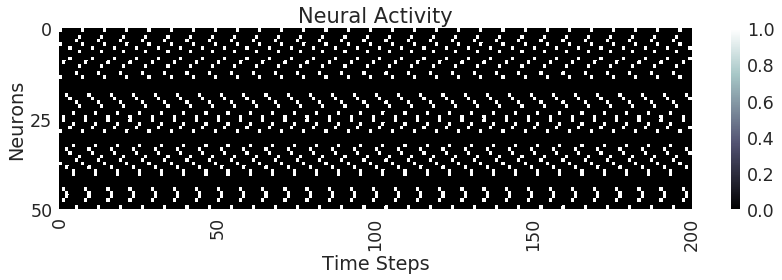

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
sns.set_style('white')
sns.set_context('notebook', font_scale=1.75)
%matplotlib inline

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Load data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Load data.
mat = loadmat('params_1_2.mat')

## Extract data.
W    = mat['w']      # Connectivity matrix.
B_e  = mat['binput'] # External input.
x0   = mat['oldx']   # Activity from previous timestep (initial conditions).
N, T = B_e.shape     # Number of neurons, number of times

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Simulate network activity.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define global inhibition.
B_i = 0.15

## Preallocate space.
X = np.zeros_like(B_e)
X[:,0] = x0.squeeze() # Store initial activity.

## Main loop.
for i in range(1, T):
    
    ## Compute excitatory inputs.
    I_e = W.dot(X[:,i-1]) + B_e[:,i-1]
    
    ## Compute inhibitory inputs.
    I_i = B_i * np.sum(X[:,i-1])
    
    ## Summate inputs, threshold, and store.
    X[:,i] = np.where(I_e - I_i > 0, 1, 0)
    
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plot.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
        
## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(12,4))
    
## Plot.
sns.heatmap(X, cmap='bone')
ax.set(xticks=np.linspace(0,T,5), xticklabels=np.linspace(0,T,5,dtype=int), xlabel='Time Steps', 
       yticks=np.linspace(0,N,3), yticklabels=np.linspace(0,N,3,dtype=int), ylabel='Neurons', 
       title='Neural Activity');
plt.tight_layout()

### 1.2a Answer

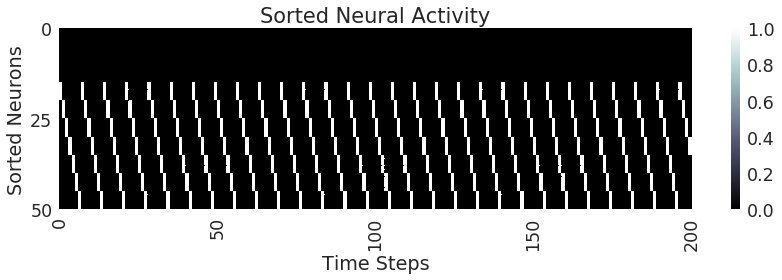

In [5]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Sort network activity.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Identify first onset of firing for each neuron.
f = lambda arr: -1 if not arr.sum() else np.argmax(arr)
first_onset = np.apply_along_axis(f, 1, X)

## Generate sorting indices by first onset.
sort_ix = np.argsort(first_onset)
ix2 = sort_ix.copy()

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plot.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
        
## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(12,4))
    
## Plot.
sns.heatmap(X[sort_ix], cmap='bone')
ax.set(xticks=np.linspace(0,T,5), xticklabels=np.linspace(0,T,5,dtype=int), xlabel='Time Steps', 
       yticks=np.linspace(0,N,3), yticklabels=np.linspace(0,N,3,dtype=int), ylabel='Sorted Neurons', 
       title='Sorted Neural Activity');
plt.tight_layout()

### 1.2b Answer
To ablate a neuron is to remove the effects of a neuron on the network. We simulate this by removing its connections. We do this for the 10th, 20th, 30th, 40th, and 50th neurons, where the rank corresponds to the sorted index as generated in 1.1a. 

In contrast to the neurons in 1.1, the synfire neurons are robust to focal damage to the network. Ablating individual neurons does not have an effect on the network. 

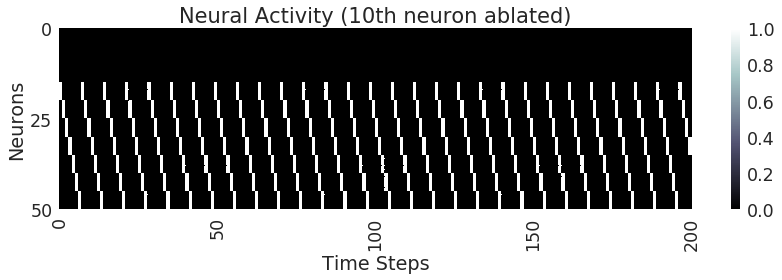

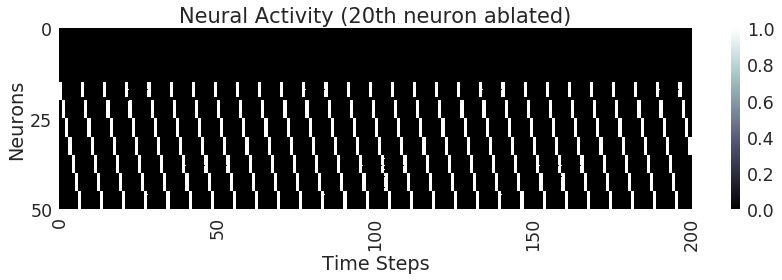

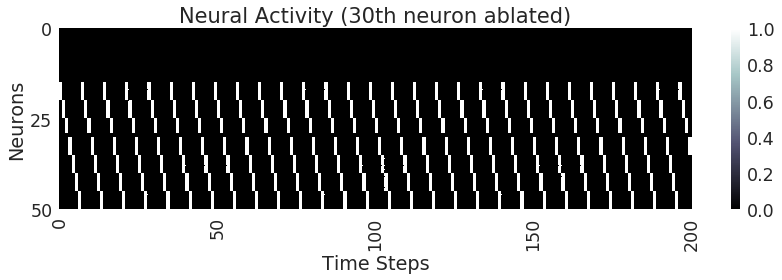

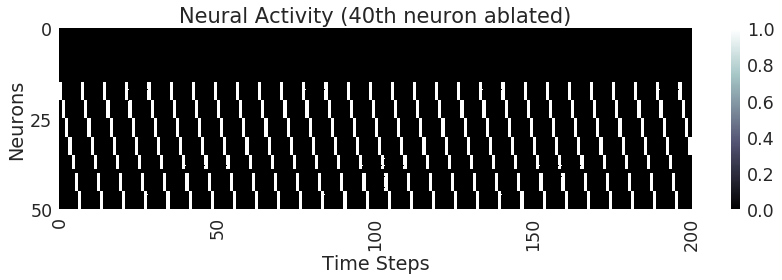

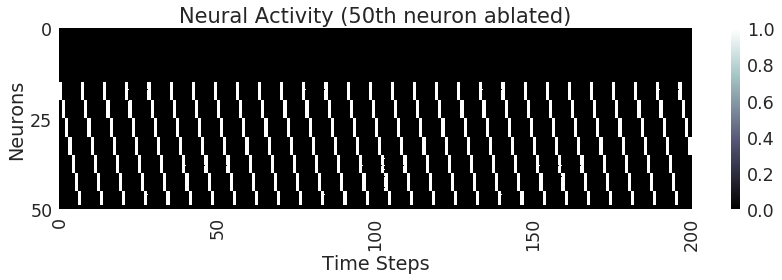

In [6]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define neurons to ablate.
targets = np.arange(10,51,10) - 1 # 0-indexing

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main loop.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

for target in targets:

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Ablate neuron.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    
    ## Define index.
    ix = sort_ix[target]
    
    ## Ablate connections.
    Wcopy = W.copy()
    Wcopy[ix] = 0
        
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Simulate network activity.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

    ## Preallocate space.
    X = np.zeros_like(B_e)
    X[:,0] = x0.squeeze() # Store initial activity.

    ## Main loop.
    for i in range(1, T):

        ## Compute excitatory inputs.
        I_e = Wcopy.dot(X[:,i-1]) + B_e[:,i-1]

        ## Compute inhibitory inputs.
        I_i = B_i * np.sum(X[:,i-1])

        ## Summate inputs, threshold, and store.
        X[:,i] = np.where(I_e - I_i > 0, 1, 0)

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Plot.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

    ## Initialize canvas.
    fig, ax = plt.subplots(1,1,figsize=(12,4))

    ## Plot.
    sns.heatmap(X[sort_ix], cmap='bone')
    ax.set(xticks=np.linspace(0,T,5), xticklabels=np.linspace(0,T,5,dtype=int), xlabel='Time Steps', 
           yticks=np.linspace(0,N,3), yticklabels=np.linspace(0,N,3,dtype=int), ylabel='Neurons', 
           title='Neural Activity (%sth neuron ablated)' %(target+1));
    plt.tight_layout()

## 2. Network architecture of sequence generation

a) Now consider the connectivity matrices of the above two networks, sort them using the same ordering of neurons as you did for the activity. Plot these sorted connectivity matrices, and explain any patterns that you see e.g. is the matrix diagonal or off-diagonal, symmetric or asymmetric etc. 

b) Network architectures can be divided into two major classes: feedforward and recurrent, with the main difference being that feedforward networks have no loops i.e. a connectivity chain starting at a given neuron never loops back to that neuron. Based on your observations from the connectivity matrices, draw a word/block diagram of the connections between the neurons involved in the sequential activity. Are these feedforward or recurrent networks? Does your answer change if you look at the connections involved within a single repetition of a sequence? Can you infer the number of possible sequences the networks can produce?

c) Now that you have discovered the network architectures, can you comment on why one of these networks is more robust than the other?

### 2a Answer
After reordering the connectivity matrix, it is clear there are striking structural differences between the two networks. The neural sequence network is predominantly characterized by a single feedforward sequence of connections in its first off-diagonal (21.5% of non-zero connections, 74.3% of connections by weight). 

In contrast, the synfire network exhibits a more densely connected structure (1150 non-zero connections, as compared to the 200 connections of the neural sequence network). The synfire network shows a greater degree of symmetry than the single sequence network, with roughly neurons of the synfire network showing approximately 15% reciprocal connections (i.e. if A $\rightarrow$ B, then B $\rightarrow$ A) as opposed to 0% of the single sequence network.

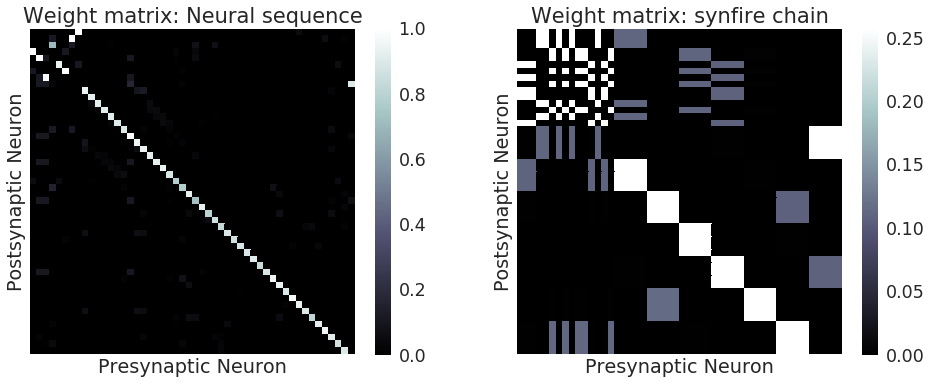

In [7]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Load data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#             

## Load data.
mat1 = loadmat('params_1_1.mat')
mat2 = loadmat('params_1_2.mat')

## Extract and sort connectivity matrix.
W1 = mat1['w']
W1 = W1[ix1][:,ix1]

## Extract and sort connectivity matrix.
W2 = mat2['w']
W2 = W2[ix2][:,ix2]

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plot.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#             

## Initialize canvas.
fig, axes = plt.subplots(1,2,figsize=(16,6))

## Plot.
sns.heatmap(W1, cmap='bone', square=True, xticklabels=[], yticklabels=[], ax=axes[0])
axes[0].set(xlabel='Presynaptic Neuron', ylabel='Postsynaptic Neuron', 
       title='Weight matrix: Neural sequence');

sns.heatmap(W2, cmap='bone', square=True, xticklabels=[], yticklabels=[], ax=axes[1])
axes[1].set(xlabel='Presynaptic Neuron', ylabel='Postsynaptic Neuron', 
       title='Weight matrix: synfire chain');

### Answer 2b
From the above, it is fairly apparent that the single sequence network is a feedforward network (i.e. no loops) whereas the synfire network is a recurrent network (i.e. loops back to a neuron). We can visualize this by making use of the [matrix powers](https://en.wikipedia.org/wiki/Adjacency_matrix#Matrix_powers) property adjacency matrices, i.e. namely that $A^n_{ij}$ is the number of directed walks of length $n$ from node $i$ to node $j$.

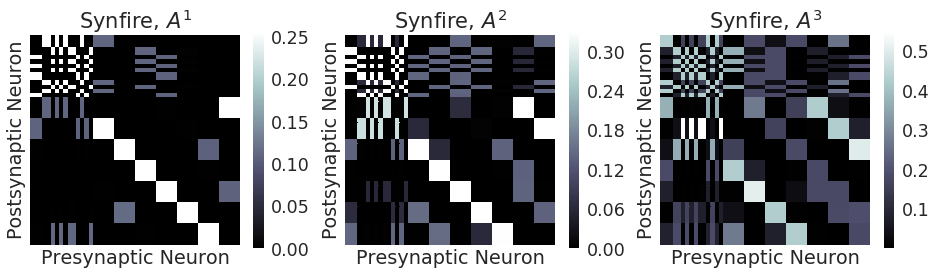

In [8]:
## Initialize canvas.
fig, axes = plt.subplots(1,3,figsize=(16,4))

## Plot.
sns.heatmap(W2, cmap='bone', square=True, xticklabels=[], yticklabels=[], ax=axes[0])
axes[0].set(xlabel='Presynaptic Neuron', ylabel='Postsynaptic Neuron', 
       title=r'Synfire, $A^1$');

sns.heatmap(W2.dot(W2), cmap='bone', square=True, xticklabels=[], yticklabels=[], ax=axes[1])
axes[1].set(xlabel='Presynaptic Neuron', ylabel='Postsynaptic Neuron', 
       title=r'Synfire, $A^2$');

sns.heatmap(W2.dot(W2).dot(W2), cmap='bone', square=True, xticklabels=[], yticklabels=[], ax=axes[2])
axes[2].set(xlabel='Presynaptic Neuron', ylabel='Postsynaptic Neuron', 
       title=r'Synfire, $A^3$');

### Answer 2c
Based on the above, the synfire network is more robust because if one neuron is ablated, on average, there are many other paths of communication from neurons presynaptic to the ablated target. 

## 3. Learning sequence generation

### 3.1 Learning using STDP
Let us now consider how a network can learn to generate this kind of sequential activity using synaptic plasticity rules. Spike-timing dependent plasticity (STDP) has been suggested as a natural candidate$^5$, given its ability to strengthen connections between sequentially activated pairs of neurons in a directional manner.

The simulation below implements STDP on the network of neurons from question 1.1, learning a connectivity matrix $W_{ij}$. 

The learning rule updates the connection weights $W_{ij}$ by the following increment $\Delta_{ij}$ on each timestep:

$$\Delta^{STDP}_{ij}(t) = \sum\limits_{\tau=0}^tx_i(t)K(\tau)x_j(t-\tau) - x_i(t-\tau)K(\tau)x_j(t) $$<br>
$$W_{ij}(t) = W_{ij}(t-1) + \eta\Delta^{STDP}_{ij}(t) $$

Where $x_i(t) =1$ represents a burst in neuron $i$ at time $t$. $t$ takes values of 0,1,2,..., and $\tau_{STDP}$ is in units of burst durations. $\eta$ is the learning rate, and K is the STDP window. K here is equal to one burst duration, $K(t) = 1$ for t=1 and 0 otherwise. $w_{max}$ is a hard bound on individual connection weights.


a) Run the simulation to produce a trained connectivity matrix, and the corresponding activity of the network. Do you see sequential activity?

b) Compare the connectivity matrix obtained here to the one of the network in section 1.1. What do you observe? 
Hint: You might want to plot the distribution of connection weights in the two matrices.

c) Can you come up with a qualitative explanation for why the trained network here doesn't behave like the network in section 1.1?

### Answer 3a
Based on the plots below, no sequential activity is observed.

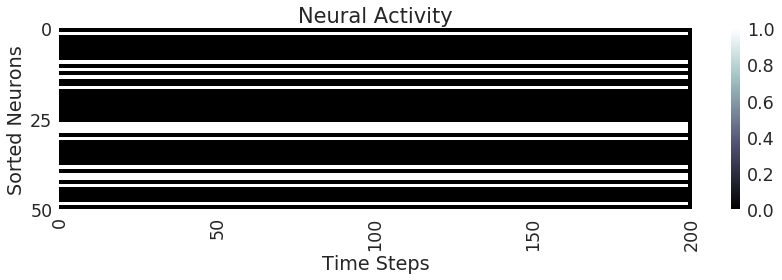

In [9]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define model parameters.
n = 50                      # number of neurons
steps = 200                 # number of timesteps
beta = 0.25                 # global inhibition strength
p = 2/n                     # probability of external stimulation during training
b = np.zeros([n,1])         # external input at any given timestep
x = np.zeros([n,1])         # network activity at any given timestep
xdyn = np.zeros([n, steps]) # network activity through all the timesteps
w = np.zeros([n,n])         # Starting with an untrained connectivity matrix

## Define training parameters.
iterations = 50             # number of training iterations
wmax = 1                    # hard bound on individual connection weight
eta = 0.125                 # learning rate
dw = np.zeros(n)            # weight increment at any given timestep
oldx = x.copy()             # network activity during training from previous timestep 

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Run simulation.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
np.random.seed(47404)

## Train the connection weights.
for iter in range(iterations-1):
    
    for i in range(steps-1):
        
        ## Random external stimulation
        b = np.random.rand(n,1)>=(1-p) 
        
        ## Propagating activity through the network
        x = (np.dot(w,oldx) - beta*sum(oldx)+ b) > 0
        
        ## Update weights using learning rule
        dw = x*np.transpose(oldx)- oldx*np.transpose(x)
        w = np.minimum(wmax, np.maximum(0, w + eta*dw - np.eye(n)*10000*wmax))
        oldx[:,0] = x[:,0]
        xdyn[:,i] = x[:,0] 

## Propogate activity through the trained network.
for i in range(0,steps-1):
    b = np.random.rand(n,1)>=(1-p)
    x = (np.dot(w,oldx) - beta*sum(oldx)+b) > 0
    oldx[:,0] = x[:,0]
    xdyn[:,i] = x[:,0] 
        
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plot.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
        
## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(12,4))
    
## Plot.
sns.heatmap(xdyn, cmap='bone')
ax.set(xticks=np.linspace(0,T,5), xticklabels=np.linspace(0,T,5,dtype=int), xlabel='Time Steps', 
       yticks=np.linspace(0,N,3), yticklabels=np.linspace(0,N,3,dtype=int), ylabel='Sorted Neurons', 
       title='Neural Activity');
plt.tight_layout()

### Answer 3b
As can be observed below, a substantially higher number of synapses are non-zero (39% vs. 8%).

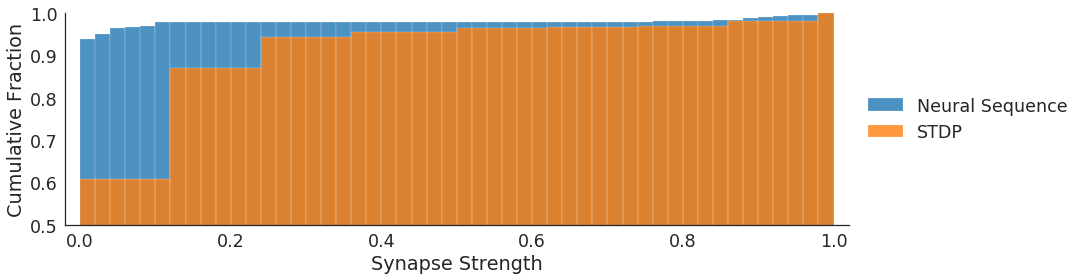

In [10]:
from pandas import DataFrame

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plot.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(12,4))

## Plot.
ax.hist(W1.flatten(), bins=50, cumulative=True, normed=True, linewidth=0.25, 
        edgecolor='w', alpha=0.8, label='Neural Sequence', color='#1f77b4')
ax.hist(w.flatten(), bins=50, cumulative=True, normed=True, linewidth=0.25, 
        edgecolor='w', alpha=0.8, label='STDP', color='#ff7f0e')
ax.set(xlim=(-2e-2,1.02), ylim=(0.5,1.0), xlabel='Synapse Strength', ylabel='Cumulative Fraction')
ax.legend(loc=7, bbox_to_anchor=(1.3,0.5))

sns.despine()
plt.tight_layout()

### Answer 3c
The network does not behave as above because there are substantially more connections that form, such that many neurons fire.

### 3.2 (BONUS) Going beyond STDP 
A number of simulation studies have demonstrated that in order to train networks to produce sequences or synfire chains, STDP alone does not suffice and additional constraints are necessary$^{6,7,8}$. Fiete et. al $^7$ proposed one such constraint, in which competition was imposed between synapses, such that when the summed weights of a neuron hit a limit, all of them underwent slight long-term depression. This rule was used in combination with STDP to learn the connectivity matrices in sections 1.1 and 1.2.

Peruse the literature and lecture slides, and describe an alternative method that can be used along with STDP to train a network to produce sequences.

## References

1. Nádasdy, Zoltán, Hajime Hirase, András Czurkó, Jozsef Csicsvari, and György Buzsáki. "Replay and time compression of recurring spike sequences in the hippocampus." The Journal of Neuroscience 19, no. 21 (1999): 9497-9507.
2. Harvey, Christopher D., Philip Coen, and David W. Tank. "Choice-specific sequences in parietal cortex during a virtual-navigation decision task." Nature 484, no. 7392 (2012): 62-68.
3. Hahnloser, Richard HR, Alexay A. Kozhevnikov, and Michale S. Fee. "An ultra-sparse code underliesthe generation of neural sequences in a songbird." Nature 419, no. 6902 (2002): 65-70.
4. Abeles, M. "Local Cortical Circuits: An Electrophysiological Approach." (1982).
5. Bi, Guo-qiang, and Mu-ming Poo. "Synaptic modification by correlated activity: Hebb's postulate revisited." Annual review of neuroscience 24.1 (2001): 139-166.
6. Suri, Roland E., and Terrence J. Sejnowski. "Spike propagation synchronized by temporally asymmetric Hebbian learning." Biological cybernetics 87, no. 5-6 (2002): 440-445.
7. Fiete, Ila R., Walter Senn, Claude ZH Wang, and Richard HR Hahnloser. "Spike-time-dependent plasticity and heterosynaptic competition organize networks to produce long scale-free sequences of neural activity." Neuron 65, no. 4 (2010): 563-576.
8. Zheng, Pengsheng, and Jochen Triesch. "Robust development of synfire chains from multiple plasticity mechanisms." Frontiers in computational neuroscience 8 (2014).
